# Assignment #2 - Cllassification

<font color="blue"> Aashwin Patki (801079127) </font>

# Overview

The aim of this assignment is to study Classification. The classification algorithms implemented in the assignment are:

* Pocket algorithm
* Quadratic Discriminant Analysis
* Linear Discriminant Analysis
* Logistic Regression

# Data

## Description

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. The task is to predict whether the basket went in (shot_made_flag).

5000 instances in the dataset have no value for (shot_made_flag). These form the test set shots. 

The field names are self explanatory and contain the following attributes:

* action_type
* combined_shot_type
* game_event_id
* game_id
* lat
* loc_x
* loc_y
* lon
* minutes_remaining
* period
* playoffs
* season 
* seconds_remaining
* shot_distance
* shot_made_flag (this is what you are predicting)
* shot_type
* shot_zone_area
* shot_zone_basic
* shot_zone_range
* team_id
* team_name
* game_date
* matchup
* opponent
* shot_id

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys

import IPython.display as ipd
from copy import deepcopy as copy
from abc import ABC, abstractmethod
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('data.csv')

print(df.shape)
df.head()

(30697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


## Plots for understanding

In [169]:
# Remove instances with missing values

#df = df.dropna()

Text(0.5,1,'lat and lon')

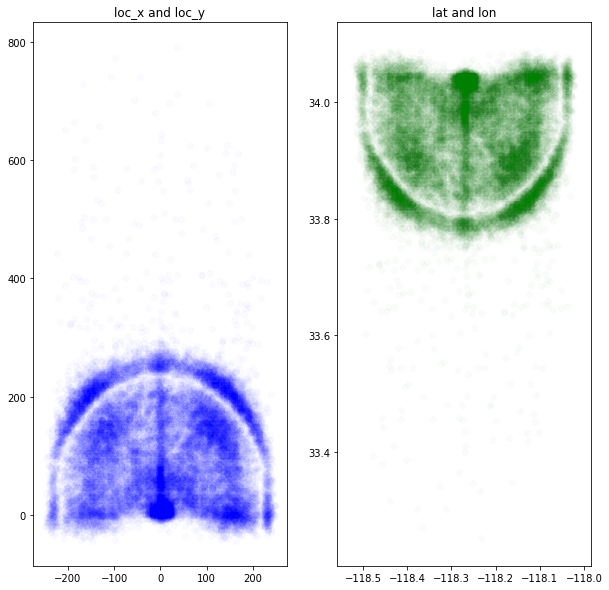

In [170]:
alpha = 0.02
plt.figure(figsize=(10,10))

# print('These plot are shaped like basket ball courts. So loc_x, loc_y, lat and lon seem to mean the position from which the ball was tossed. However, since the region under the net is half-circle-shaped, it would be more suitable to transform the variable into polar coodinate.')

# loc_x and loc_y
plt.subplot(121)
plt.scatter(df.loc_x, df.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122)
plt.scatter(df.lon, df.lat, color='green', alpha=alpha)
plt.title('lat and lon')

In [171]:
#Conversion of the above attributes to polar co-ordinates
df['dist'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)

loc_x_zero = df['loc_x'] == 0
df['angle'] = np.array([0]*len(df))
df['angle'][~loc_x_zero] = np.arctan(df['loc_y'][~loc_x_zero] / df['loc_x'][~loc_x_zero])
df['angle'][loc_x_zero] = np.pi / 2 

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [172]:
df['remaining_time'] = df['minutes_remaining'] * 60 + df['seconds_remaining']

In [173]:
from sklearn.preprocessing import LabelEncoder
labelEncoder_df = LabelEncoder()
df.action_type = labelEncoder_df.fit_transform(df.action_type)
df.combined_shot_type = labelEncoder_df.fit_transform(df.combined_shot_type)
df.shot_type = labelEncoder_df.fit_transform(df.shot_type)

In [174]:
print(df['season'].unique())

# Converting the season attribute to a numerical value
df['season'] = df['season'].apply(lambda x: int(x.split('-')[1]))
print(df['season'].unique())

#Note that all the attributes to be dropped have been dropped together at the end of this section.
print(df['team_id'].unique())
print(df['team_name'].unique())

pd.DataFrame({'matchup':df.matchup, 'opponent':df.opponent})
df.opponent = labelEncoder_df.fit_transform(df.opponent)


['2000-01' '2001-02' '2002-03' '2003-04' '2004-05' '2005-06' '2006-07'
 '2007-08' '2008-09' '2009-10' '2010-11' '2011-12' '2012-13' '2013-14'
 '2014-15' '2015-16' '1996-97' '1997-98' '1998-99' '1999-00']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 97 98 99  0]
[1610612747]
['Los Angeles Lakers']


Text(0.5,1,'dist and shot_distance')

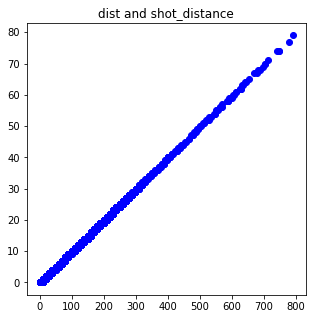

In [175]:
plt.figure(figsize=(5,5))

plt.scatter(df.dist, df.shot_distance, color='blue')
plt.title('dist and shot_distance')

The attributes *shot_zone_area, shot_zone_basic, shot_zone_range* are dropped as they are directly related to the location from which the shot was taken.

Text(0.5,1,'shot_zone_range')

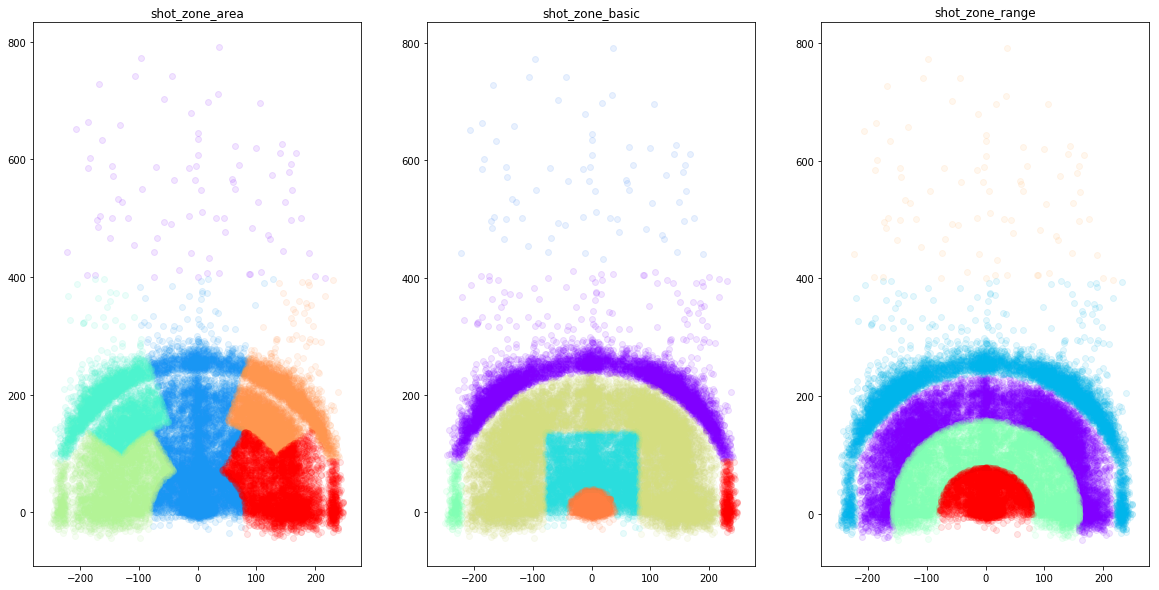

In [176]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = df.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [177]:
#Dropping all the attributes mentione above:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']
df_clean = df.drop(columns=drops)

In [178]:
df_clean.head()

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,opponent,dist,angle,remaining_time
0,26,3,1,0,1,NaN,0,25,181.859836,0.407058,627
1,26,3,1,0,1,0.0,0,25,157.000000,-0.000000,622
2,26,3,1,0,1,1.0,0,25,168.600119,-0.928481,465
3,26,3,1,0,1,0.0,0,25,222.865430,0.903063,412
4,5,1,2,0,1,1.0,0,25,0.000000,1.570796,379


In [179]:
df_clean.shape
#print(df.shape)


(30697, 11)

## Preliminary observation

As seen from the above plots, the attributes *shot_zone_area, shot_zone_basic, shot_zone_range, loc_x, loc_y, lat, lon, shot_distance* are all related. Hence, they are dropped and the x, y positions are converted to polar form. The attributes *team_id and team_name* have a unique value hence are dropped from further analysis. All the categorical values are converted.

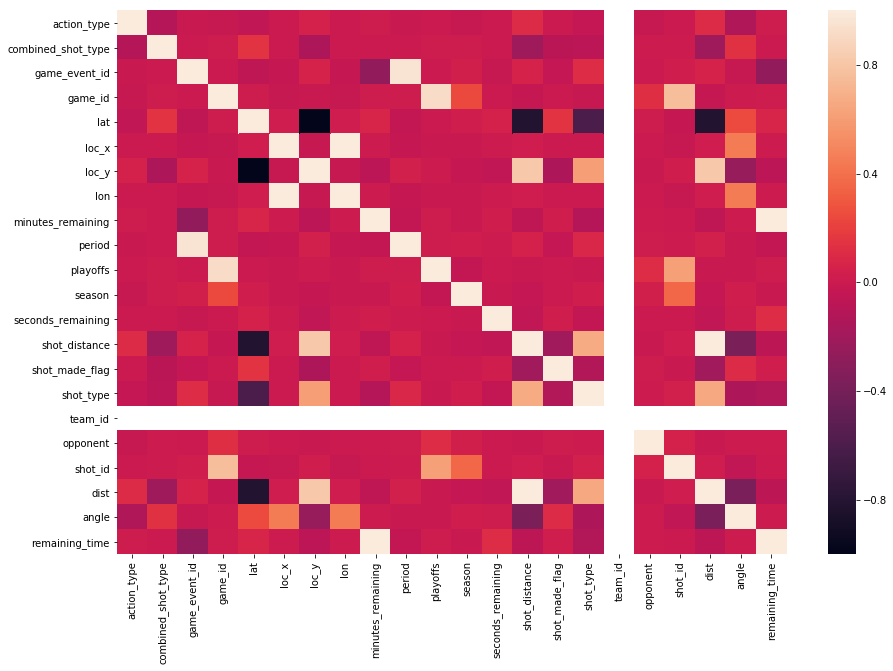

In [180]:
corr = df.corr()

plt.rcParams['figure.figsize'] = [15, 10]

#plt.subplots(figsize=(15,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

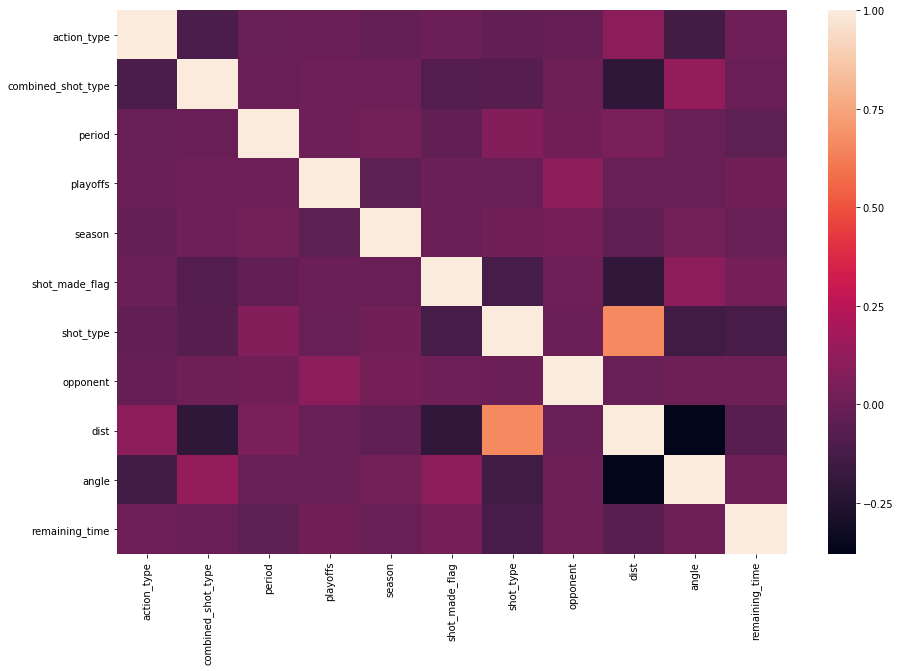

In [181]:
corr1 = df_clean.corr()

sns.heatmap(corr1,
           xticklabels=corr1.columns,
           yticklabels=corr1.columns)

In [242]:
# Splitting the training testing datasets

df_copy = df_clean[pd.notnull(df_clean['shot_made_flag'])]
Xtest = df_clean[pd.isnull(df_clean['shot_made_flag'])]
Xtest = Xtest.drop('shot_made_flag', 1)

Xtrain = df_copy.drop('shot_made_flag', 1)
Ttrain = df_copy['shot_made_flag']

Tptrain = df_copy.shot_made_flag.replace(to_replace=0.0, value=-1)


(5000, 10)


# Methods

In [246]:
# Super class for machine learning models 

class BaseModel(ABC):
    """ Super class for ITCS Machine Learning Class"""
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    

class Classifier(BaseModel):
    """
        Abstract class for classification 
        
        Attributes
        ==========
        meanX       ndarray
                    mean of inputs (from standardization)
        stdX        ndarray
                    standard deviation of inputs (standardization)
    """

    def __init__(self, ):
        self.meanX = None
        self.stdX = None

    def normalize(self, X):
        """ standardize the input X """
        
        if not isinstance(X, np.ndarray):
            X = np.asanyarray(X)

        self.meanX = np.mean(X, 0)
        self.stdX = np.std(X, 0)

        # TODO: Finish this normalization
        Xs = X - self.meanX / self.stdX
        return Xs

    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abstractmethod
    def train(self, X, T):
        pass
    
    @abstractmethod
    def use(self, X):
        pass 

## Summary of Classification models

## Explanation of code

The Pocket algorithm is an improvement over the perceptron algorithm. In the perceptron algorithm, the weights keep changing in each iteration. The weights in one iteration may be worse than the ones calculated in the previous iteration. Hence, in the pocket algorithm, the result of the weights calculated so far and the result of the new weights is compared. The weights which offer better results, are stored for the next iteration.

The model is implemented using a Pocket class which inherits the base class and overrides the train and use methods. A compare method is added to the class which compares the results of the previous weights and the new weights.

### Pocket

In [247]:
# Pocket Algorithm

class Pocket(Classifier):
    
    def __init__(self, alpha):
        Classifier.__init__(self)
        self.alpha = alpha
        self.w = None
        self.w_pocket = None
    
    def compare(self, X, T, w, wp):
        y = np.sign(X @ w)
        yp = np.sign(X @ wp)
        
        return 1 if np.sum(y == T) >= np.sum(yp == T) else -1
        
    def train(self, X, T):
        #X = self.normalize(X)
        
        if self.w is None or self.w_pocket is None:
            self.w = np.zeros(X.shape[1])
            self.w_pocket = np.zeros(X.shape[1])
            
        for i in range(1000):
            converged = True
            for k in np.random.permutation(X.shape[0]):
                y = self.w @ X[k]
                if np.sign(y) != np.sign(T[k]):
                    self.w += self.alpha * T[k] * X[k]
                    converged = False
                    if self.compare(X, T, self.w, self.w_pocket) > 0:
                        self.w_pocket[:] = self.w[:]
                       
            if converged:
                print("converged at ", i)
                break
                
        # pass
    
    def use(self, X):
        return X @ self.w_pocket
        pass

### QDA

In this approach, a decision boundary is defined by calculating the posterior and prior probabilities. The data is assumed to follow Gaussian Distribution. For this approach, the means, covariances and prior probabilities. The probability that one instance belongs to a class is calculated by considering the mean, covariance and prior probability for the target. 

In a binary classification problem, $k \in \{-1, +1\}$, we have a higher posterior probability $P(T = +1 \mid \xv)$ for the sample $\xv$ with the positive label. Thus, 

$$
P(T = +1 \mid \xv) > P(T = -1 \mid \xv).
$$

The inequality will be the opposite in case of the negative samples. 

$$
\begin{align*}
  P(T = +1 \mid \xv) &> P(T = -1 \mid \xv) \\
  \\
  \frac{P(\xv \mid T = +1) P(T = +1)} { P(\xv) } &> \frac{P(\xv \mid T = -1) P(T = -1)} { P(\xv) } \\
  \\
  P(\xv \mid T = +1) P(T = +1)  &> P(\xv \mid T = -1) P(T = -1) \\
  \\
  \Big( (2\pi)^{\frac{d}{2}} \vert \boldsymbol\Sigma_+ \vert^{\frac{1}{2}} \Big)^{-1} e^{ -\frac{1}{2} (\xv - \boldsymbol\mu_+)^\top \boldsymbol\Sigma_+^{-1} (\xv - \boldsymbol\mu_+)} P(T = +1)  &>
  \Big( (2\pi)^{\frac{d}{2}} \vert \boldsymbol\Sigma_- \vert^{\frac{1}{2}} \Big)^{-1} e^{ -\frac{1}{2} (\xv - \boldsymbol\mu_-)^\top \boldsymbol\Sigma_-^{-1} (\xv - \boldsymbol\mu_-)} P(T = -1) \\
  \\
  \Big( \vert \boldsymbol\Sigma_+ \vert^{\frac{1}{2}} \Big)^{-1} e^{ -\frac{1}{2} (\xv - \boldsymbol\mu_+)^\top \boldsymbol\Sigma_+^{-1} (\xv - \boldsymbol\mu_+)} P(T = +1)  &>
  \Big( \vert \boldsymbol\Sigma_- \vert^{\frac{1}{2}} \Big)^{-1} e^{ -\frac{1}{2} (\xv - \boldsymbol\mu_-)^\top \boldsymbol\Sigma_-^{-1} (\xv - \boldsymbol\mu_-)} P(T = -1) 
\end{align*}
$$

$$
-\frac{1}{2} \ln \vert \boldsymbol\Sigma_+ \vert - \frac{1}{2} (\xv - \boldsymbol\mu_+)^\top \boldsymbol\Sigma_+^{-1} (\xv - \boldsymbol\mu_+) + \ln P(T = +1) > -\frac{1}{2} \ln \vert \boldsymbol\Sigma_- \vert - \frac{1}{2} (\xv - \boldsymbol\mu_-)^\top \boldsymbol\Sigma_-^{-1} (\xv - \boldsymbol\mu_-) + \ln P(T = -1)
$$

From the observation that both terms have the same cosmetics, we can define the discriminant function $\delta_k(\xv)$ as

$$
\delta_k(\xv) = -\frac{1}{2} \ln \vert \boldsymbol\Sigma_k \vert - \frac{1}{2} (\xv - \boldsymbol\mu_k)^\top \boldsymbol\Sigma_k^{-1} (\xv - \boldsymbol\mu_k) + \ln P(T = k). 
$$

Now, for a new sample $\tilde{\xv}$, the label can be predicted with

$$
y = \arg\max_k \delta_k(\tilde{\xv}). 
$$

The decision boundary is placed where the discriminant functions meet such as $\delta_1 == \delta_2$. 

Since the $\delta_k$ function is quadratic in $\xv$, the decision boundary is quadratic. 



In my implementation of the QDA model, the use method is used to calculate the decision boundary.

In [225]:
# QDA

class QuadDisc(Classifier):
    
    def __init__(self):
        Classifier.__init__(self)
        
    def use(self, X, mu, sigma, prior):
        sigma_inv = np.linalg.inv(sigma)
        diffv = X - mu
        return -0.5 * np.log(np.linalg.det(sigma)) \
                -0.5 * np.sum(diffv @ sigma_inv * diffv, axis=1) \
                + np.log(prior)
    
    #def train(self, X, T):
    #    pass
    
    def train(self, X):
        pass

In [244]:
dfa = np.array(df_clean)

df1 = dfa[dfa[:, 5] == 0]
df2 = dfa[dfa[:, 5] == 1]

N1 = df1.shape[0]
N2 = df2.shape[0]
N = N1 + N2

prior1 = N1 / N
prior2 = N2 / N

means, stds = np.mean(dfa, 0), np.std(dfa, 0)

mu1 = np.mean(df1, 0)
mu2 = np.mean(df2, 0)

Sigma = np.cov(dfa.T)

xs, ys = np.meshgrid(np.linspace(-3, -8, 100), np.linspace(-3, -8, 100))
#print(xs.shape)
#Xtest = np.vstack((xs.flat, ys.flat)).T
#XtestS = (Xtest-means)/stds'''

#print(xs)

qda = QuadDisc()

#print(Xtest.shape)
#print(df1)
d1 = qda.use(Xtest, mu1, Sigma, prior1)
#print(d1)
d2 = qda.use(Xtest, mu2, Sigma, prior2)


fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

ax.plot_surface(xs, ys, d1[:10000].reshape(xs.shape), alpha=0.2)
ax.plot_surface(xs, ys, d2[:10000].reshape(xs.shape), alpha=0.4)

plt.title("QDA Discriminant Functions")
plt.figure(figsize=(6,6))
plt.contourf(xs, ys, ((d1[:10000]-d2[:10000]).reshape(xs.shape) > 0))
plt.title("Decision Boundary")


ValueError: Unable to coerce to Series, length must be 10: given 11

### LDA

In [245]:
# LDA

class LinDisc(Classifier):
    
    def __init__(self):
        Classifier.__init__(self)
        
    def use(self, X, mu, sigma, prior):
        sigma_inv = np.linalg.inv(sigma)
        return np.sum(np.dot(X, sigma_inv) * mu \
                - 0.5 * np.dot(mu, sigma_inv) * mu \
                + np.log(prior), axis=1)
        # pass
    
    def train(self):
        pass
        

### Logistic Regression

In [219]:
# Logistic Regression

class LogisticRegress(Classifier):
    
    def __init__(self, alpha):
        Classifier.__init__(self)
        self.w = None
        self.alpha = alpha
        
    def train(self, X, T):
        X1 = self.add_ones(X)
        
        if self.w is None:
            self.w = np.zeros((X1.shape[1], T.shape[1]))
        
        likeli = []
        for step in range(1000):
            ys = g(X1, self.w)
            self.w += (self.alpha) * X1.T @ (T - ys)
            
#            ipd.clear_output(wait=True)
#            ipd.display(fig)
#        ipd.clear_output(wait=True)
            
        # pass
    
    def use(self, X):
        X1 = self.add_ones(X)
        return X1 @ self.w
        # pass
    
def softmax(z):
        if not isinstance(z, np.ndarray):
            z = np.asarray(z)
        f = np.exp(z)
        return f / (np.sum(f, axis=1, keepdims=True) if len(z.shape) == 2 else np.sum(f))
    
def g(X, w):
    return softmax(X @ w)

# Experiments

## Discussions about evaluation metrics

## Discussions about train and test accuracies

## plots for results (5 for each algorithm)

## Discussions about classification model comparison

Text(0.5,0,'QDA P(x|Class=k)\n from disc funcs')

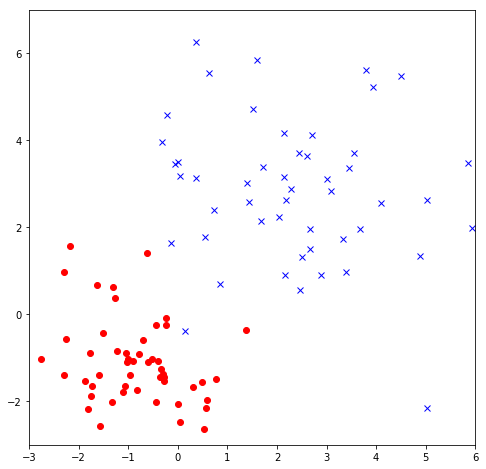

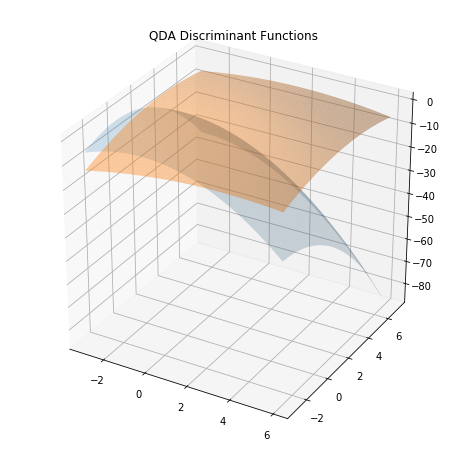

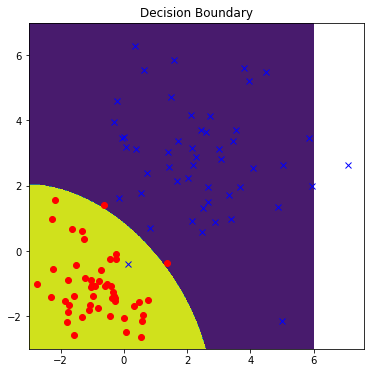

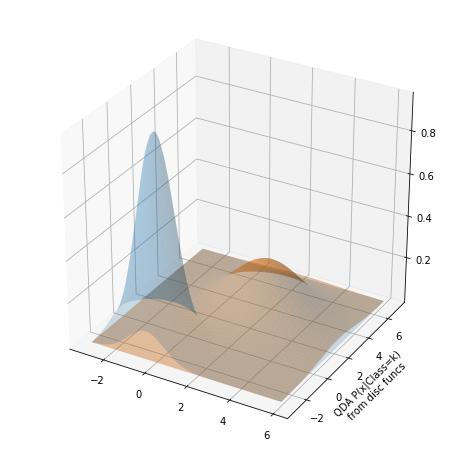

In [259]:
# Preliminary Tests

mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

C1 = np.random.multivariate_normal(mu1, cov1, 50)
C2 = np.random.multivariate_normal(mu2, cov2, 50)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])

X = np.vstack((C1, C2))
T = np.ones(100)
T[:50] *= -1

# Train and Test data
N1 = C1.shape[0]
N2 = C2.shape[0]
N = N1 + N2

Xtrain = np.vstack((C1, C2))
Ttrain = np.ones(80)
Ttrain[:N1] *= -1

#np.sum(np.dot(diffv, sigma_inv) * diffv, axis=1) \

# QDA train

## compute the mean and covariance

means, stds = np.mean(Xtrain, 0), np.std(Xtrain, 0)
Xs = (Xtrain - means) / stds

mu1 = np.mean(Xs[:N1], 0)
mu2 = np.mean(Xs[N1:], 0)

Sigma1 = np.cov(Xs[:N1].T)
Sigma2 = np.cov(Xs[N1:].T)


prior1 = N1 / N
prior2 = N2 / N

## now compute the discriminant function on test data

xs, ys = np.meshgrid(np.linspace(-3,6, 500), np.linspace(-3,7, 500))
Xtest = np.vstack((xs.flat, ys.flat)).T
XtestS = (Xtest-means)/stds

qda = QuadDisc()


d1 = qda.use(XtestS, mu1, Sigma1, prior1)
d2 = qda.use(XtestS, mu2, Sigma2, prior2)


fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xs, ys, d1.reshape(xs.shape), alpha=0.2)
ax.plot_surface(xs, ys, d2.reshape(xs.shape), alpha=0.4)
plt.title("QDA Discriminant Functions")

plt.figure(figsize=(6,6))
plt.contourf(xs, ys, (d1-d2 > 0).reshape(xs.shape))
plt.title("Decision Boundary")
plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

# Plot generative distributions  p(x | Class=k)  starting with discriminant functions

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

prob1 = np.exp( d1.reshape(xs.shape) - 0.5*X.shape[1]*np.log(2*np.pi) - np.log(prior1))
prob2 = np.exp( d2.reshape(xs.shape) - 0.5*X.shape[1]*np.log(2*np.pi) - np.log(prior2))
ax.plot_surface(xs, ys, prob1, alpha=0.2)
ax.plot_surface(xs, ys, prob2, alpha=0.4)


plt.ylabel("QDA P(x|Class=k)\n from disc funcs", multialignment="center")


(500, 500)
(250000,)


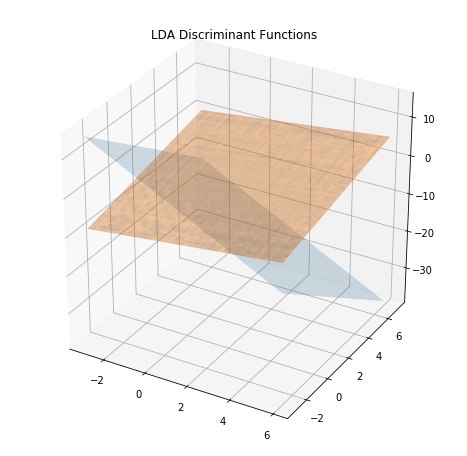

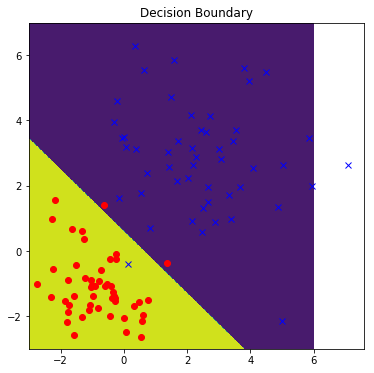

In [260]:
# LDA

xs, ys = np.meshgrid(np.linspace(-3,6, 500), np.linspace(-3,7, 500))
Xtest = np.vstack((xs.flat, ys.flat)).T
XtestS = (Xtest-means)/stds

lda = LinDisc()

d1 = lda.use(XtestS, mu1, Sigma1, prior1)
d2 = lda.use(XtestS, mu2, Sigma2, prior2)

print(xs.shape)
print(d1.shape)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xs, ys, d1.reshape(xs.shape), alpha=0.2)
ax.plot_surface(xs, ys, d2.reshape(xs.shape), alpha=0.4)
plt.title("LDA Discriminant Functions")

plt.figure(figsize=(6,6))
plt.contourf(xs, ys, (d1-d2 > 0).reshape(xs.shape))
plt.title("Decision Boundary")
plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')


(-3, 7)

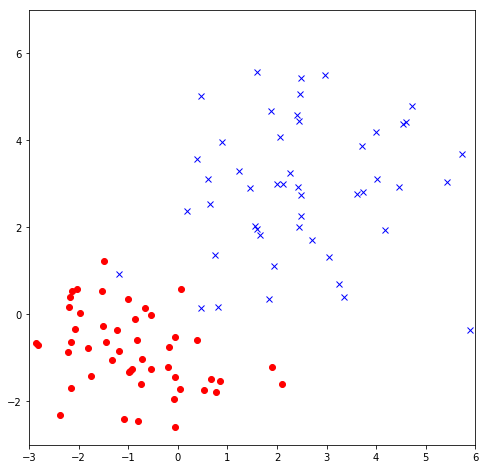

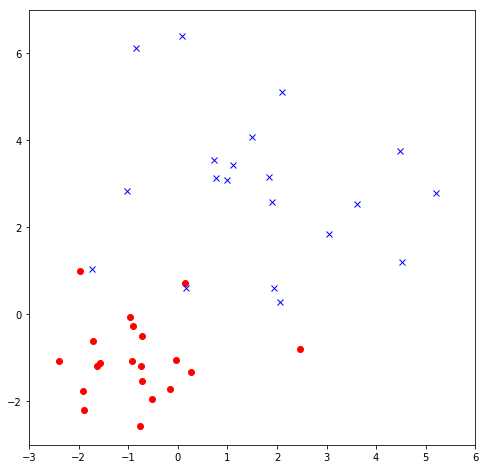

In [261]:
# Preliminary Tests

# Data for testing
N1 = 50
N2 = 50
N = N1 + N2
D = 2
K = 2

mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

#fig = plt.figure(figsize=(16,8))

plt.rcParams['figure.figsize'] = [8, 8]

#
#  Train Data
#
C1 = np.random.multivariate_normal(mu1, cov1, N1)
C2 = np.random.multivariate_normal(mu2, cov2, N2)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])

Xtrain = np.vstack((C1, C2))
Ttrain = np.zeros((N, 2))
Ttrain[:50, 0] = 1
Ttrain[50:, 1] = 1

Tptrain = np.ones(Xtrain.shape[0])
Tptrain[:50] *= -1

means, stds = np.mean(Xtrain, 0), np.std(Xtrain, 0)
# normalize inputs
Xtrains = (Xtrain - means) / stds

#
#  Test Data
#
Ct1 = np.random.multivariate_normal(mu1, cov1, 20)
Ct2 = np.random.multivariate_normal(mu2, cov2, 20)

Xtest = np.vstack((Ct1, Ct2))
Ttest = np.zeros((40, 2))
Ttest[:20, 0] = 1
Ttest[20:, 1] = 1

# normalize inputs
Xtests = (Xtrain - means) / stds


plt.figure()
plt.plot(Ct1[:, 0], Ct1[:, 1], 'or')
plt.plot(Ct2[:, 0], Ct2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])


In [262]:
ls = LogisticRegress(0.1)

ls.train(Xtrain, Ttrain)

y = ls.use(Xtrain)

X1train = np.hstack((np.ones((Xtrain.shape[0], 1)), Xtrain))

#print(Xtrain.shape)
#print(X1train.shape)

ls.w

y = g(X1train, ls.w)

print(y)

[[9.99945129e-01 5.48710679e-05]
 [9.99999947e-01 5.26220145e-08]
 [9.99999965e-01 3.46610225e-08]
 [9.74706847e-01 2.52931531e-02]
 [9.96893275e-01 3.10672452e-03]
 [9.99999999e-01 1.27671663e-09]
 [9.99920804e-01 7.91958592e-05]
 [9.99992727e-01 7.27347974e-06]
 [9.99391597e-01 6.08402814e-04]
 [9.99361499e-01 6.38500724e-04]
 [9.99969465e-01 3.05352551e-05]
 [9.99999051e-01 9.49325536e-07]
 [9.94087811e-01 5.91218919e-03]
 [9.99986767e-01 1.32331614e-05]
 [9.94424886e-01 5.57511419e-03]
 [9.99997379e-01 2.62143997e-06]
 [9.60339121e-01 3.96608794e-02]
 [6.00163105e-01 3.99836895e-01]
 [9.80332179e-01 1.96678209e-02]
 [9.99999930e-01 6.95009254e-08]
 [9.99816633e-01 1.83367187e-04]
 [9.99989829e-01 1.01708689e-05]
 [9.99942451e-01 5.75488723e-05]
 [9.99989969e-01 1.00308594e-05]
 [9.99877040e-01 1.22960338e-04]
 [9.99999681e-01 3.18595556e-07]
 [9.12361356e-01 8.76386445e-02]
 [9.99999333e-01 6.67077009e-07]
 [9.99998995e-01 1.00548424e-06]
 [9.99904619e-01 9.53809345e-05]
 [9.999152

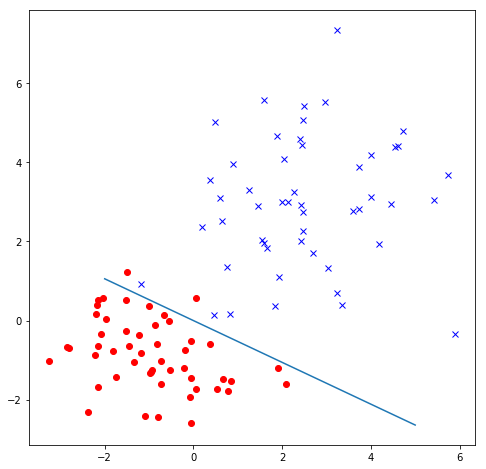

In [263]:
p = Pocket(0.1)

#print(Xtrain.shape)
#print(Tptrain)

p.train(Xtrain, Tptrain)

y = -p.w_pocket[0] * Xtrain / p.w_pocket[1]

#print(y)
#print(p.w_pocket)

plt.plot(Xtrain[:50, 0], Xtrain[:50, 1], 'or')
plt.plot(Xtrain[50:, 0], Xtrain[50:, 1], 'xb')
#plt.plot(Tptrain[:, 0], Tptrain)

xt = np.array([-2, 5])
yt = -p.w_pocket[0] * xt / p.w_pocket[1]

plt.plot(xt, yt)


# Conclusions

The assignment is difficult.

# References

* https://www.kaggle.com/c/kobe-bryant-shot-selection/data
* https://www.kaggle.com/dixhom/data-analysis-for-beginners